In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns



def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimensiㄴon
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

# standardize features using training statistics (keep split as-is)
mu = X_train.mean(axis=(0,1), keepdims=True)
sigma = X_train.std(axis=(0,1), keepdims=True) + 1e-8
X_train = ((X_train - mu) / sigma).astype('float32')
X_val = ((X_val - mu) / sigma).astype('float32')
testX = ((testX - mu) / sigma).astype('float32')
X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

C:\Users\이예일\AppData\Local\Temp\ipykernel_23180\2308141114.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
C:\Users\이예일\AppData\Local\Temp\ipykernel_23180\2308141114.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
C:\Users\이예일\AppData\Local\Temp\ipykernel_23180\2308141114.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
C:\Users\이예일\AppData\Local\Temp\ipykernel_23180\2308141114.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [2]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, ReLU,
    Add, GlobalAveragePooling1D, Dropout, Dense
)

## Lightweight 1D ResNet

def residual_block(x, filters, kernel_size):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x); x = ReLU()(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

inputs = Input(shape=(n_timesteps, n_features))
x = Conv1D(64, kernel_size=7, padding='same')(inputs)
x = BatchNormalization()(x); x = ReLU()(x)

x = residual_block(x, 64, 3)
x = residual_block(x, 64, 3)
x = residual_block(x, 128, 3)
x = residual_block(x, 128, 3)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.4)(x)
dense = Dense(128, activation='relu')(x)
outputs = Dense(n_outputs, activation='softmax')(dense)
resnet_model = Model(inputs, outputs)
resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
resnet_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 64)   │      4,096 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 128, 64)   │     12,352 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 64)   │     12,352 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 64)   │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 64)   │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 128, 64)   │     12,352 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 128, 64)   │     12,352 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 64)   │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 128, 64)   │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 128, 128)  │     24,704 │ re_lu_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 255,494 (998.02 KB)

 Trainable params: 253,574 (990.52 KB)

 Non-trainable params: 1,920 (7.50 KB)

In [4]:
from tensorflow.keras.callbacks import EarlyStopping
model_history=resnet_model.fit(
    x=X_train,
    y=y_train_one_hot,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=20, min_delta=1e-4, restore_best_weights=True)]
)


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.7791 - loss: 0.6273 - val_accuracy: 0.9083 - val_loss: 0.2256
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9355 - loss: 0.1493 - val_accuracy: 0.9508 - val_loss: 0.1173
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9397 - loss: 0.1571 - val_accuracy: 0.9440 - val_loss: 0.1207
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9474 - loss: 0.1254 - val_accuracy: 0.9474 - val_loss: 0.1162
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9459 - loss: 0.1245 - val_accuracy: 0.9491 - val_loss: 0.1033
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9459 - loss: 0.1342 - val_accuracy: 0.9559 - val_loss: 0.0905
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9587 - loss: 0.1027 - val_accuracy: 0.9440 - val_loss: 0.1085
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9456 - loss: 0.1279 - val_accuracy: 0.9304 - v

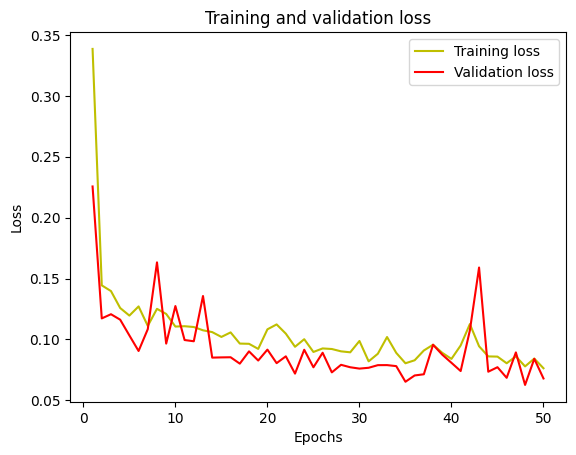

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
     

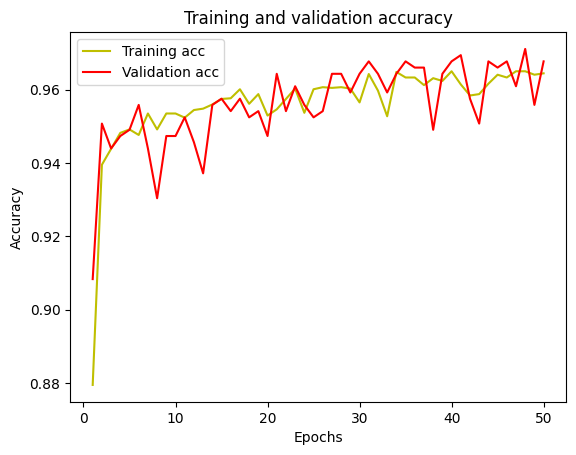

In [6]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[[496   0   0   0   0   0]
 [  1 449  21   0   0   0]
 [  0   0 420   0   0   0]
 [  0   1   0 406  76   8]
 [  1   0   0  63 468   0]
 [  0   0   0   0   0 537]]
0.9419748897183576
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       496
           1       1.00      0.95      0.98       471
           2       0.95      1.00      0.98       420
           3       0.87      0.83      0.85       491
           4       0.86      0.88      0.87       532
           5       0.99      1.00      0.99       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



<Axes: >

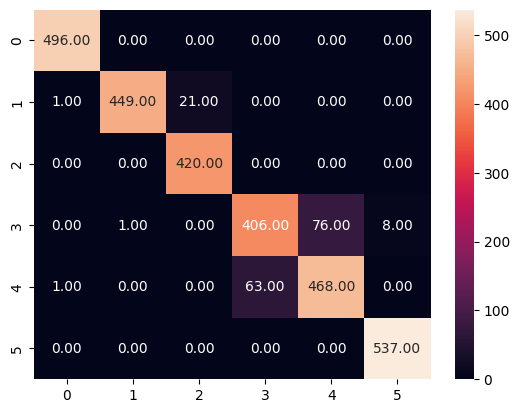

In [7]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=resnet_model.predict(testX)
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')
